In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
df = pd.read_csv("data456.csv")
df.head()

,Applied Loan Amount,Applied Loan Tenor,Loan Purpose,Gender,Age,Marital Status,Education Level,Residential Status,Monthly Housing/Rental,Contract Staff (Y/N),Employment Type,Nature of Business,Job Position,Monthly Income,Office (Area)_1,Office (Area)_2,Office (Area)_3,Office (Area)_6,Indicators
0,60000,24,Car Purchase,M,22.301,Single,Secondary,Live With Relatives,0.0,N,Fixed Income Earner,Sales,Private,10245.0,0,1,0,0,0
1,100000,60,Settle Loan / Credit Card O/S,M,33.159,Single,Form 3 or below,Live With Relatives,0.0,N,Fixed Income Earner,Services,Private,10000.0,1,0,0,0,0
2,50000,24,Personal use,F,28.389,Married,University,Rental,2000.0,N,Fixed Income Earner,Services,Private,9700.0,0,0,1,0,0
3,70000,36,Personal use,M,35.573,Married,Post Graduate,Rental,1200.0,N,Civil Servant,Manager,Government/Semi-Government,23000.0,0,1,0,0,0
4,300000,60,Settle Loan / Credit Card O/S,F,30.849,Single,University,Mortgaged Private Housing,11000.0,N,Fixed Income Earner,Manager,Private,34000.0,1,0,0,0,0


In [3]:
df = df.dropna()

In [4]:
# df = df.astype(np.float64)
# df["Final_Status (Y/N)"].astype(int)
df.dtypes

Applied Loan Amount         int64
Applied Loan Tenor          int64
Loan Purpose               object
Gender                     object
Age                       float64
Marital Status             object
Education Level            object
Residential Status         object
Monthly Housing/Rental    float64
Contract Staff (Y/N)       object
Employment Type            object
Nature of Business         object
Job Position               object
Monthly Income            float64
Office (Area)_1             int64
Office (Area)_2             int64
Office (Area)_3             int64
Office (Area)_6             int64
Indicators                  int64
dtype: object

In [5]:
df = pd.get_dummies(df)
df.head()

,Applied Loan Amount,Applied Loan Tenor,Age,Monthly Housing/Rental,Monthly Income,Office (Area)_1,Office (Area)_2,Office (Area)_3,Office (Area)_6,Indicators,Loan Purpose_Birth Giving,Loan Purpose_Business,Loan Purpose_Car Purchase,Loan Purpose_Decoration,Loan Purpose_Education,Loan Purpose_Funeral Expenses,Loan Purpose_Investment,Loan Purpose_Marriage,Loan Purpose_Medical Expenses,Loan Purpose_Personal use,Loan Purpose_Settle Loan / Credit Card O/S,Loan Purpose_Stand by,Loan Purpose_Tax Payment,Loan Purpose_Traveling,Gender_F,Gender_M,Marital Status_Divorced,Marital Status_Married,Marital Status_No Response,Marital Status_Separated,Marital Status_Single,Marital Status_Widowed,Education Level_Form 3 or below,Education Level_No Response,Education Level_Post Graduate,Education Level_Post Secondary,Education Level_Primary,Education Level_Secondary,Education Level_University,Residential Status_Company Provision,...,Residential Status_Rental,Residential Status_Self-owned Private Housing,Residential Status_Self-owned Public Housing,Contract Staff (Y/N)_N,Contract Staff (Y/N)_Y,Employment Type_Civil Servant,Employment Type_Fixed Income Earner,Employment Type_Non Fixed Income Earner,Employment Type_Not Applicable,Employment Type_Self-Employed,Employment Type_Self-Employed Professional,Nature of Business_All Other,Nature of Business_Construction Trades,Nature of Business_Driver,Nature of Business_Executive,Nature of Business_Factory Worker,Nature of Business_Guard,Nature of Business_Homemaker,Nature of Business_Manager,Nature of Business_No Response,Nature of Business_Office Worker,Nature of Business_Owner of a Business,Nature of Business_Professional,Nature of Business_Retired,Nature of Business_Sales,Nature of Business_Semi Professional,Nature of Business_Services,Nature of Business_Skilled Worker,Nature of Business_Student,Nature of Business_Unemployed,Nature of Business_Unskilled Worker,Job Position_Government/Semi-Government,Job Position_Homemaker,Job Position_No Response,Job Position_Private,Job Position_Public,Job Position_Retired,Job Position_Self Employed,Job Position_Student,Job Position_Unemployed
0,60000,24,22.301,0.0,10245.0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,100000,60,33.159,0.0,10000.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
2,50000,24,28.389,2000.0,9700.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,...,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
3,70000,36,35.573,1200.0,23000.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,...,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,300000,60,30.849,11000.0,34000.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [6]:
cols = df.columns.tolist()
cols.remove('Indicators')
cols.append('Indicators')
df = df[cols]
df.head() 

,Applied Loan Amount,Applied Loan Tenor,Age,Monthly Housing/Rental,Monthly Income,Office (Area)_1,Office (Area)_2,Office (Area)_3,Office (Area)_6,Loan Purpose_Birth Giving,Loan Purpose_Business,Loan Purpose_Car Purchase,Loan Purpose_Decoration,Loan Purpose_Education,Loan Purpose_Funeral Expenses,Loan Purpose_Investment,Loan Purpose_Marriage,Loan Purpose_Medical Expenses,Loan Purpose_Personal use,Loan Purpose_Settle Loan / Credit Card O/S,Loan Purpose_Stand by,Loan Purpose_Tax Payment,Loan Purpose_Traveling,Gender_F,Gender_M,Marital Status_Divorced,Marital Status_Married,Marital Status_No Response,Marital Status_Separated,Marital Status_Single,Marital Status_Widowed,Education Level_Form 3 or below,Education Level_No Response,Education Level_Post Graduate,Education Level_Post Secondary,Education Level_Primary,Education Level_Secondary,Education Level_University,Residential Status_Company Provision,Residential Status_Live With Relatives,...,Residential Status_Self-owned Private Housing,Residential Status_Self-owned Public Housing,Contract Staff (Y/N)_N,Contract Staff (Y/N)_Y,Employment Type_Civil Servant,Employment Type_Fixed Income Earner,Employment Type_Non Fixed Income Earner,Employment Type_Not Applicable,Employment Type_Self-Employed,Employment Type_Self-Employed Professional,Nature of Business_All Other,Nature of Business_Construction Trades,Nature of Business_Driver,Nature of Business_Executive,Nature of Business_Factory Worker,Nature of Business_Guard,Nature of Business_Homemaker,Nature of Business_Manager,Nature of Business_No Response,Nature of Business_Office Worker,Nature of Business_Owner of a Business,Nature of Business_Professional,Nature of Business_Retired,Nature of Business_Sales,Nature of Business_Semi Professional,Nature of Business_Services,Nature of Business_Skilled Worker,Nature of Business_Student,Nature of Business_Unemployed,Nature of Business_Unskilled Worker,Job Position_Government/Semi-Government,Job Position_Homemaker,Job Position_No Response,Job Position_Private,Job Position_Public,Job Position_Retired,Job Position_Self Employed,Job Position_Student,Job Position_Unemployed,Indicators
0,60000,24,22.301,0.0,10245.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,...,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,100000,60,33.159,0.0,10000.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,...,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,50000,24,28.389,2000.0,9700.0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,70000,36,35.573,1200.0,23000.0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,300000,60,30.849,11000.0,34000.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [7]:
df.shape

(11661, 84)

In [8]:
# df['Class_att'] = df['Class_att'].astype('category')
# encode_map = {
#     'Abnormal': 1,
#     'Normal': 0
# }

# df['Class_att'].replace(encode_map, inplace=True)

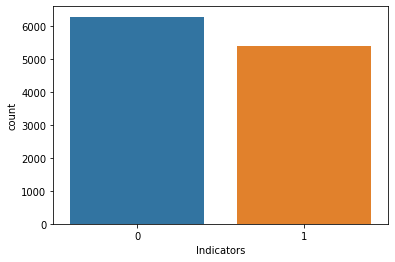

In [9]:
sns.countplot(x = 'Indicators', data=df)

In [10]:
X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]

In [11]:
print(X.shape, y.shape)

(11661, 83) (11661,)


In [12]:
np.any(np.isnan(y))

False

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [14]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [15]:
print(X_train.shape, X_test.shape)

(7812, 83) (3849, 83)


In [16]:
EPOCHS = 100
BATCH_SIZE = 64
LEARNING_RATE = 0.001

In [17]:
## train data
class trainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = trainData(torch.FloatTensor(X_train), 
                       torch.FloatTensor(torch.Tensor(y_train.values)))
## test data    
class testData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

test_data = testData(torch.FloatTensor(X_test))

In [18]:
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1) # may need increase later

In [19]:
class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()
        # Number of input features is 12.
        self.layer_1 = nn.Linear(83, 160) 
        self.layer_2 = nn.Linear(160, 40)
        self.layer_out = nn.Linear(40, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(160)
        self.batchnorm2 = nn.BatchNorm1d(40)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
###############

cpu


In [21]:
model = binaryClassification()
model.to(device)
print(model)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

binaryClassification(
  (layer_1): Linear(in_features=83, out_features=160, bias=True)
  (layer_2): Linear(in_features=160, out_features=40, bias=True)
  (layer_out): Linear(in_features=40, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [22]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [23]:
model.train()
e_loss = []
e_acc = []
timelist = []
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    start_time = time.time()
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    total_time = time.time() - start_time
    timelist.append(total_time)
    e_loss.append(epoch_loss/len(train_loader)) # for plt
    e_acc.append(epoch_acc/len(train_loader)) # for plt
    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f} | Time: {total_time:.3f}')

Epoch 001: | Loss: 0.73429 | Acc: 51.496 | Time: 0.611
Epoch 002: | Loss: 0.67960 | Acc: 58.837 | Time: 0.436
Epoch 003: | Loss: 0.64061 | Acc: 64.577 | Time: 0.427
Epoch 004: | Loss: 0.62463 | Acc: 65.772 | Time: 0.434
Epoch 005: | Loss: 0.61243 | Acc: 68.049 | Time: 0.433
Epoch 006: | Loss: 0.59949 | Acc: 69.358 | Time: 0.425
Epoch 007: | Loss: 0.58868 | Acc: 70.407 | Time: 0.432
Epoch 008: | Loss: 0.58537 | Acc: 69.976 | Time: 0.424
Epoch 009: | Loss: 0.58227 | Acc: 70.398 | Time: 0.437
Epoch 010: | Loss: 0.57737 | Acc: 70.683 | Time: 0.423
Epoch 011: | Loss: 0.57484 | Acc: 71.374 | Time: 0.424
Epoch 012: | Loss: 0.56875 | Acc: 72.171 | Time: 0.433
Epoch 013: | Loss: 0.56677 | Acc: 72.195 | Time: 0.453
Epoch 014: | Loss: 0.56483 | Acc: 71.846 | Time: 0.428
Epoch 015: | Loss: 0.56620 | Acc: 72.049 | Time: 0.424
Epoch 016: | Loss: 0.56330 | Acc: 71.919 | Time: 0.430
Epoch 017: | Loss: 0.55922 | Acc: 72.366 | Time: 0.429
Epoch 018: | Loss: 0.55860 | Acc: 72.634 | Time: 0.429
Epoch 019:

In [24]:
n_list = np.arange(1, 501).tolist()
n_list = pd.Series(n_list)
time_list = pd.Series(timelist)

In [25]:
time_list.corr(n_list)

-0.18448012127579905

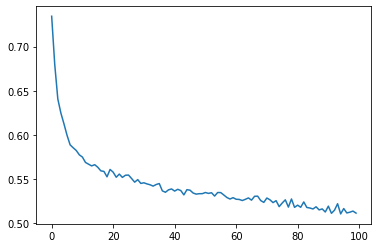

In [26]:
plt.plot(e_loss)

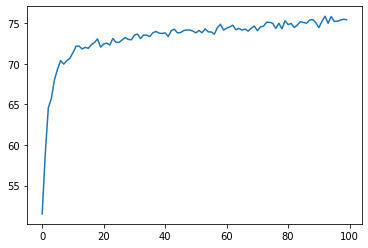

In [27]:
plt.plot(e_acc)

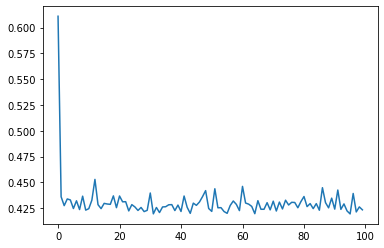

In [28]:
plt.plot(timelist)

In [33]:
import statistics
statistics.mean(timelist)

0.43034690618515015

In [29]:
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [30]:
confusion_matrix(y_test, y_pred_list)

array([[1644,  443],
       [ 573, 1189]])

In [31]:
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.74      0.79      0.76      2087
           1       0.73      0.67      0.70      1762

    accuracy                           0.74      3849
   macro avg       0.74      0.73      0.73      3849
weighted avg       0.74      0.74      0.73      3849

